In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gc
import time
import subprocess
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import polars as pl
from typing import Dict, List, Tuple, Optional, Union
from pathlib import Path
from tqdm import tqdm

In [2]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem.MACCSkeys import GenMACCSKeys
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

/home/arer90/anaconda3/envs/tf/lib/python3.12/site-packages/optuna/study/_optimize.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [ ]:
# PyTorch device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

In [6]:
from pathlib import Path
from extra_code.molecular_loader_with_fp import (
    load_split_data,
    extract_xy_from_data,
    build_fingerprints_for_splits,
    check_cache_status
)

In [7]:
target_path = "result/2_standard_comp"
os.makedirs(target_path, exist_ok=True)
out_root = Path("./result/fingerprint")
out_root.mkdir(parents=True, exist_ok=True)

In [8]:
# Model hyperparameters
RANDOM_STATE = 42
VAL_SIZE = 0.1
EPOCHS = 100
BATCHSIZE = 32
REGULARIZER = 1e-5
lr = 0.001
CV = 5

# Split mapping
SPLIT_MAP = {
    "rm": "random",
    "cs": "chemical_space_coverage", 
    "cl": "cluster",
    "pc": "physchem",
    "ac": "activity_cliff",
    "sa": "solubility_aware",
    "en": "ensemble"
}

# Dataset abbreviation mapping
DATASET_MAP = {
    "delaney-processed": "de",
    "Lovric2020_logS0": "lo",
    "ws496_logS": "ws",
    "huusk": "hu"
}

In [9]:
# Font sizes for publication quality
FONT_SIZES = {
    'title': 30,
    'subtitle': 24,
    'label': 26,
    'tick': 20,
    'legend': 22,
    'legend_small': 18
}

# QSAR Solubility Criteria Colors
QSAR_COLORS = {
    'High': '#8ECAE6',    # Vibrant light blue
    'Good': '#A7C957',    # Light green
    'Low': '#FFD166',     # Light orange/yellow
    'Poor': '#EF476F'     # Light red/salmon
}

# QSAR Criteria Labels
QSAR_LABELS = [
    'High Solubility (LogS > -2)',
    'Good Solubility (-4 < LogS ≤ -2)',
    'Low Solubility (-6 < LogS ≤ -4)',
    'Poor Solubility (LogS ≤ -6)'
]

def extract_target_values(df: pd.DataFrame, target_column: str) -> np.ndarray:
    """Extract target values from dataframe."""
    if target_column not in df.columns:
        # Try to find any column with 'log' in name
        log_cols = [col for col in df.columns if 'log' in col.lower()]
        if log_cols:
            target_column = log_cols[0]
        else:
            raise KeyError(f"Column '{target_column}' not found in dataframe. "
                          f"Available columns: {list(df.columns)}")
    
    return df[target_column].astype(float).values

def add_qsar_background(ax: plt.Axes, x_min: float, x_max: float, alpha: float = 0.5):
    """Add QSAR solubility criteria background to axis."""
    ax.axvspan(-2, x_max, facecolor=QSAR_COLORS['High'], alpha=alpha, zorder=0)
    ax.axvspan(-4, -2, facecolor=QSAR_COLORS['Good'], alpha=alpha, zorder=0)
    ax.axvspan(-6, -4, facecolor=QSAR_COLORS['Low'], alpha=alpha*1.2, zorder=0)
    ax.axvspan(x_min, -6, facecolor=QSAR_COLORS['Poor'], alpha=alpha*1.2, zorder=0)

def create_qsar_legend_handles(alpha: float = 0.5):
    """Create legend handles for QSAR criteria."""
    return [
        plt.Rectangle((0,0), 1, 1, facecolor=QSAR_COLORS['High'], alpha=alpha),
        plt.Rectangle((0,0), 1, 1, facecolor=QSAR_COLORS['Good'], alpha=alpha),
        plt.Rectangle((0,0), 1, 1, facecolor=QSAR_COLORS['Low'], alpha=alpha*1.2),
        plt.Rectangle((0,0), 1, 1, facecolor=QSAR_COLORS['Poor'], alpha=alpha*1.2)
    ]

def plot_logs_distribution_multiple(
    datasets: List[Tuple[pd.DataFrame, str, str]],
    output_path: Optional[str] = None,
    plot_type: str = 'subplots',
    figsize: Optional[Tuple[int, int]] = None,
    layout: Optional[Tuple[int, int]] = None,
    show_qsar: bool = True,
    show_stats: bool = True,
    bins: Union[int, str] = 30,
    colors: Optional[List[str]] = None,
    alpha: float = 0.6
) -> plt.Figure:
    """Plot LogS distributions for multiple datasets."""
    
    if plot_type == 'subplots':
        return _plot_multiple_subplots(
            datasets, output_path, figsize, layout, 
            show_qsar, show_stats, bins, colors
        )
    elif plot_type == 'overlay':
        return _plot_multiple_overlay(
            datasets, output_path, figsize, 
            show_qsar, show_stats, bins, colors, alpha
        )
    else:
        raise ValueError(f"plot_type must be 'subplots' or 'overlay', got '{plot_type}'")

def _plot_multiple_subplots(
    datasets: List[Tuple[pd.DataFrame, str, str]],
    output_path: Optional[str],
    figsize: Optional[Tuple[int, int]],
    layout: Optional[Tuple[int, int]],
    show_qsar: bool,
    show_stats: bool,
    bins: Union[int, str],
    colors: Optional[List[str]]
) -> plt.Figure:
    """Internal function for subplot visualization."""
    n_datasets = len(datasets)
    
    # Determine layout
    if layout is None:
        layout = (2, 2) if n_datasets <= 4 else (3, 3)
    
    # Set figure size
    if figsize is None:
        figsize = (24, 16)
    
    # Set style and create figure
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize,
                            sharex=True, sharey=True)
    
    if n_datasets == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Set colors
    if colors is None:
        colors = sns.color_palette("Set1", n_colors=n_datasets)
    
    # Extract all data for common bins
    all_data = []
    for df, target_col, _ in datasets:
        data = extract_target_values(df, target_col)
        all_data.extend(data)
    
    all_data = np.array(all_data)
    hist_bins = np.histogram_bin_edges(all_data, bins=bins)
    global_min = all_data.min() - 0.5
    global_max = all_data.max() + 0.5
    
    # Plot each dataset
    for i, (df, target_col, name) in enumerate(datasets):
        if i >= len(axes):
            break
        
        ax = axes[i]
        data = extract_target_values(df, target_col)
        
        # Set limits
        ax.set_xlim(global_min, global_max)
        
        # Add QSAR background
        if show_qsar:
            add_qsar_background(ax, global_min, global_max)
        
        # Plot histogram
        ax.hist(data, bins=hist_bins, density=True,
                color=colors[i], label=name, zorder=2,
                alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Set title
        if show_stats:
            stats = {
                'count': len(data),
                'mean': np.mean(data),
                'std': np.std(data)
            }
            title = f"{name}\n(n={stats['count']}, μ={stats['mean']:.2f}, σ={stats['std']:.2f})"
        else:
            title = name
        
        ax.set_title(title, fontsize=FONT_SIZES['subtitle'])
        ax.tick_params(axis='both', labelsize=FONT_SIZES['tick'])
        
        # Y-axis label positioning
        if i % layout[1] == 0:  # Left column
            ax.set_ylabel('Density', fontsize=FONT_SIZES['label'])
        elif i % layout[1] == layout[1] - 1:  # Right column
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_ylabel('Density', fontsize=FONT_SIZES['label'])
        
        # Grid
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.grid(axis='x', visible=False)
    
    # Hide unused subplots
    for i in range(n_datasets, len(axes)):
        axes[i].set_visible(False)
    
    # Common labels
    fig.supxlabel('Experimental LogS Value', fontsize=FONT_SIZES['label'], y=0.04)
    fig.suptitle('Distribution of Experimental LogS Values by Dataset',
                 fontsize=FONT_SIZES['title'], y=0.98)
    
    # Add QSAR legend
    if show_qsar:
        qsar_handles = create_qsar_legend_handles()
        fig.legend(qsar_handles, QSAR_LABELS,
                   loc='center left', bbox_to_anchor=(0.95, 0.5),
                   fontsize=FONT_SIZES['legend'],
                   title='QSAR Solubility Criteria',
                   title_fontsize=FONT_SIZES['legend'])
    
    # Adjust layout
    fig.tight_layout(rect=[0.06, 0.06, 0.95, 0.93])
    
    # Save if requested
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig

def _plot_multiple_overlay(
    datasets: List[Tuple[pd.DataFrame, str, str]],
    output_path: Optional[str],
    figsize: Optional[Tuple[int, int]],
    show_qsar: bool,
    show_stats: bool,
    bins: Union[int, str],
    colors: Optional[List[str]],
    alpha: float
) -> plt.Figure:
    """Internal function for overlay visualization."""
    # Implementation similar to subplots but with overlaid histograms
    pass  # Simplified for brevity

def plot_original_datasets_distribution():
    """Plot distribution for original datasets (ws496, delaney, lovric, huuskonen)"""
    
    # Try to load original datasets
    try:
        datasets = []
        
        # ws496
        df1 = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
        datasets.append((df1, 'exp', 'ws496'))
        
        # Delaney
        df2 = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
        datasets.append((df2, 'ESOL predicted log solubility in mols per litre', 'Delaney (ESOL)'))
        
        # Lovric
        df3 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
        datasets.append((df3, 'logS0', 'Lovrić et al.'))
        
        # Huuskonen
        df4 = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'Solubility', 'Huuskonen'))
        
        # Create visualization
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets.png',
            plot_type='subplots',
            layout=(2, 2),
            figsize=(24, 16)
        )
        
    except FileNotFoundError as e:
        print(f"Warning: {e.filename} not found. Using dummy data.")
        # Generate dummy data for demonstration
        np.random.seed(0)
        datasets = [
            (pd.DataFrame({'logS': np.random.normal(-3, 2, 496)}), 'logS', 'ws496'),
            (pd.DataFrame({'logS': np.random.normal(-2.5, 1.5, 1144)}), 'logS', 'Delaney (ESOL)'),
            (pd.DataFrame({'logS': np.random.normal(-3.5, 2.5, 998)}), 'logS', 'Lovrić et al.'),
            (pd.DataFrame({'logS': np.random.normal(-4, 2.2, 1297)}), 'logS', 'Huuskonen')
        ]
        
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets_Dummy.png',
            plot_type='subplots'
        )

In [10]:
def plot_original_datasets_distribution2():
    """Plot distribution for original datasets (ws496, delaney, lovric, huuskonen)"""
    
    # Try to load original datasets
    try:
        datasets = []
        
        # # ws496
        # df1 = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
        # datasets.append((df1, 'exp', 'ws496'))
        
        # # Delaney
        # df2 = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
        # datasets.append((df2, 'ESOL predicted log solubility in mols per litre', 'Delaney (ESOL)'))
        
        # # Lovric
        # df3 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
        # datasets.append((df3, 'logS0', 'Lovrić et al.'))
        
        # # Huuskonen
        # df4 = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
        # datasets.append((df4, 'Solubility', 'Huuskonen'))
        
        # SAMPL
        df4 = pd.read_csv('./data/SAMPL.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'expt', 'SAMPL'))
        
        # Lipophilicity
        df4 = pd.read_csv('./data/Lipophilicity.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'exp', 'Lipophilicity'))
        
        # AqSolDB
        df4 = pd.read_csv('./data/curated-solubility-dataset.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'Solubility', 'AqSolDB'))
        
        # # BigSolDB
        # df4 = pd.read_csv('./extra_code/BigSolDB.csv', dtype={'SMILES': 'string'})
        # datasets.append((df4, 'Solubility', 'BigSolDB'))
        
        # Create visualization
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets2.png',
            plot_type='subplots',
            layout=(3, 1), # 4:3
            figsize=(24, 16)
        )
        
    except FileNotFoundError as e:
        print(f"Warning: {e.filename} not found. Using dummy data.")
        # Generate dummy data for demonstration
        np.random.seed(0)
        datasets = [
            (pd.DataFrame({'logS': np.random.normal(-3, 2, 496)}), 'logS', 'ws496'),
            (pd.DataFrame({'logS': np.random.normal(-2.5, 1.5, 1144)}), 'logS', 'Delaney (ESOL)'),
            (pd.DataFrame({'logS': np.random.normal(-3.5, 2.5, 998)}), 'logS', 'Lovrić et al.'),
            (pd.DataFrame({'logS': np.random.normal(-4, 2.2, 1297)}), 'logS', 'Huuskonen')
        ]
        
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets_Dummy.png',
            plot_type='subplots'
        )

In [37]:
def plot_original_datasets_distribution3():
    """Plot distribution for original datasets (ws496, delaney, lovric, huuskonen)"""
    
    # Try to load original datasets
    try:
        datasets = []
        
        # # ws496
        # df1 = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
        # datasets.append((df1, 'exp', 'ws496'))
        
        # # Delaney
        # df2 = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
        # datasets.append((df2, 'ESOL predicted log solubility in mols per litre', 'Delaney (ESOL)'))
        
        # # Lovric
        # df3 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
        # datasets.append((df3, 'logS0', 'Lovrić et al.'))
        
        # # Huuskonen
        # df4 = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
        # datasets.append((df4, 'Solubility', 'Huuskonen'))
        
        # SAMPL
        df4 = pd.read_csv('./data/SAMPL.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'expt', 'SAMPL'))
        
        # Lipophilicity
        df4 = pd.read_csv('./data/Lipophilicity.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'exp', 'Lipophilicity'))
        
        # AqSolDB
        df4 = pd.read_csv('./data/curated-solubility-dataset.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'Solubility', 'AqSolDB'))
        
        # BigSolDB
        df4 = pd.read_csv('./data/BigSolDB.csv', dtype={'SMILES': 'string'})
        datasets.append((df4, 'Solubility', 'BigSolDB'))
        
        # Create visualization
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets3.png',
            plot_type='subplots',
            layout=(2, 2), # 4:3
            figsize=(24, 16)
        )
        
    except FileNotFoundError as e:
        print(f"Warning: {e.filename} not found. Using dummy data.")
        # Generate dummy data for demonstration
        np.random.seed(0)
        datasets = [
            (pd.DataFrame({'logS': np.random.normal(-3, 2, 496)}), 'logS', 'ws496'),
            (pd.DataFrame({'logS': np.random.normal(-2.5, 1.5, 1144)}), 'logS', 'Delaney (ESOL)'),
            (pd.DataFrame({'logS': np.random.normal(-3.5, 2.5, 998)}), 'logS', 'Lovrić et al.'),
            (pd.DataFrame({'logS': np.random.normal(-4, 2.2, 1297)}), 'logS', 'Huuskonen')
        ]
        
        plot_logs_distribution_multiple(
            datasets,
            output_path='./result/2_standard_comp/LogS_Original_Datasets_Dummy.png',
            plot_type='subplots'
        )

Saved: ./result/2_standard_comp/LogS_Original_Datasets.png


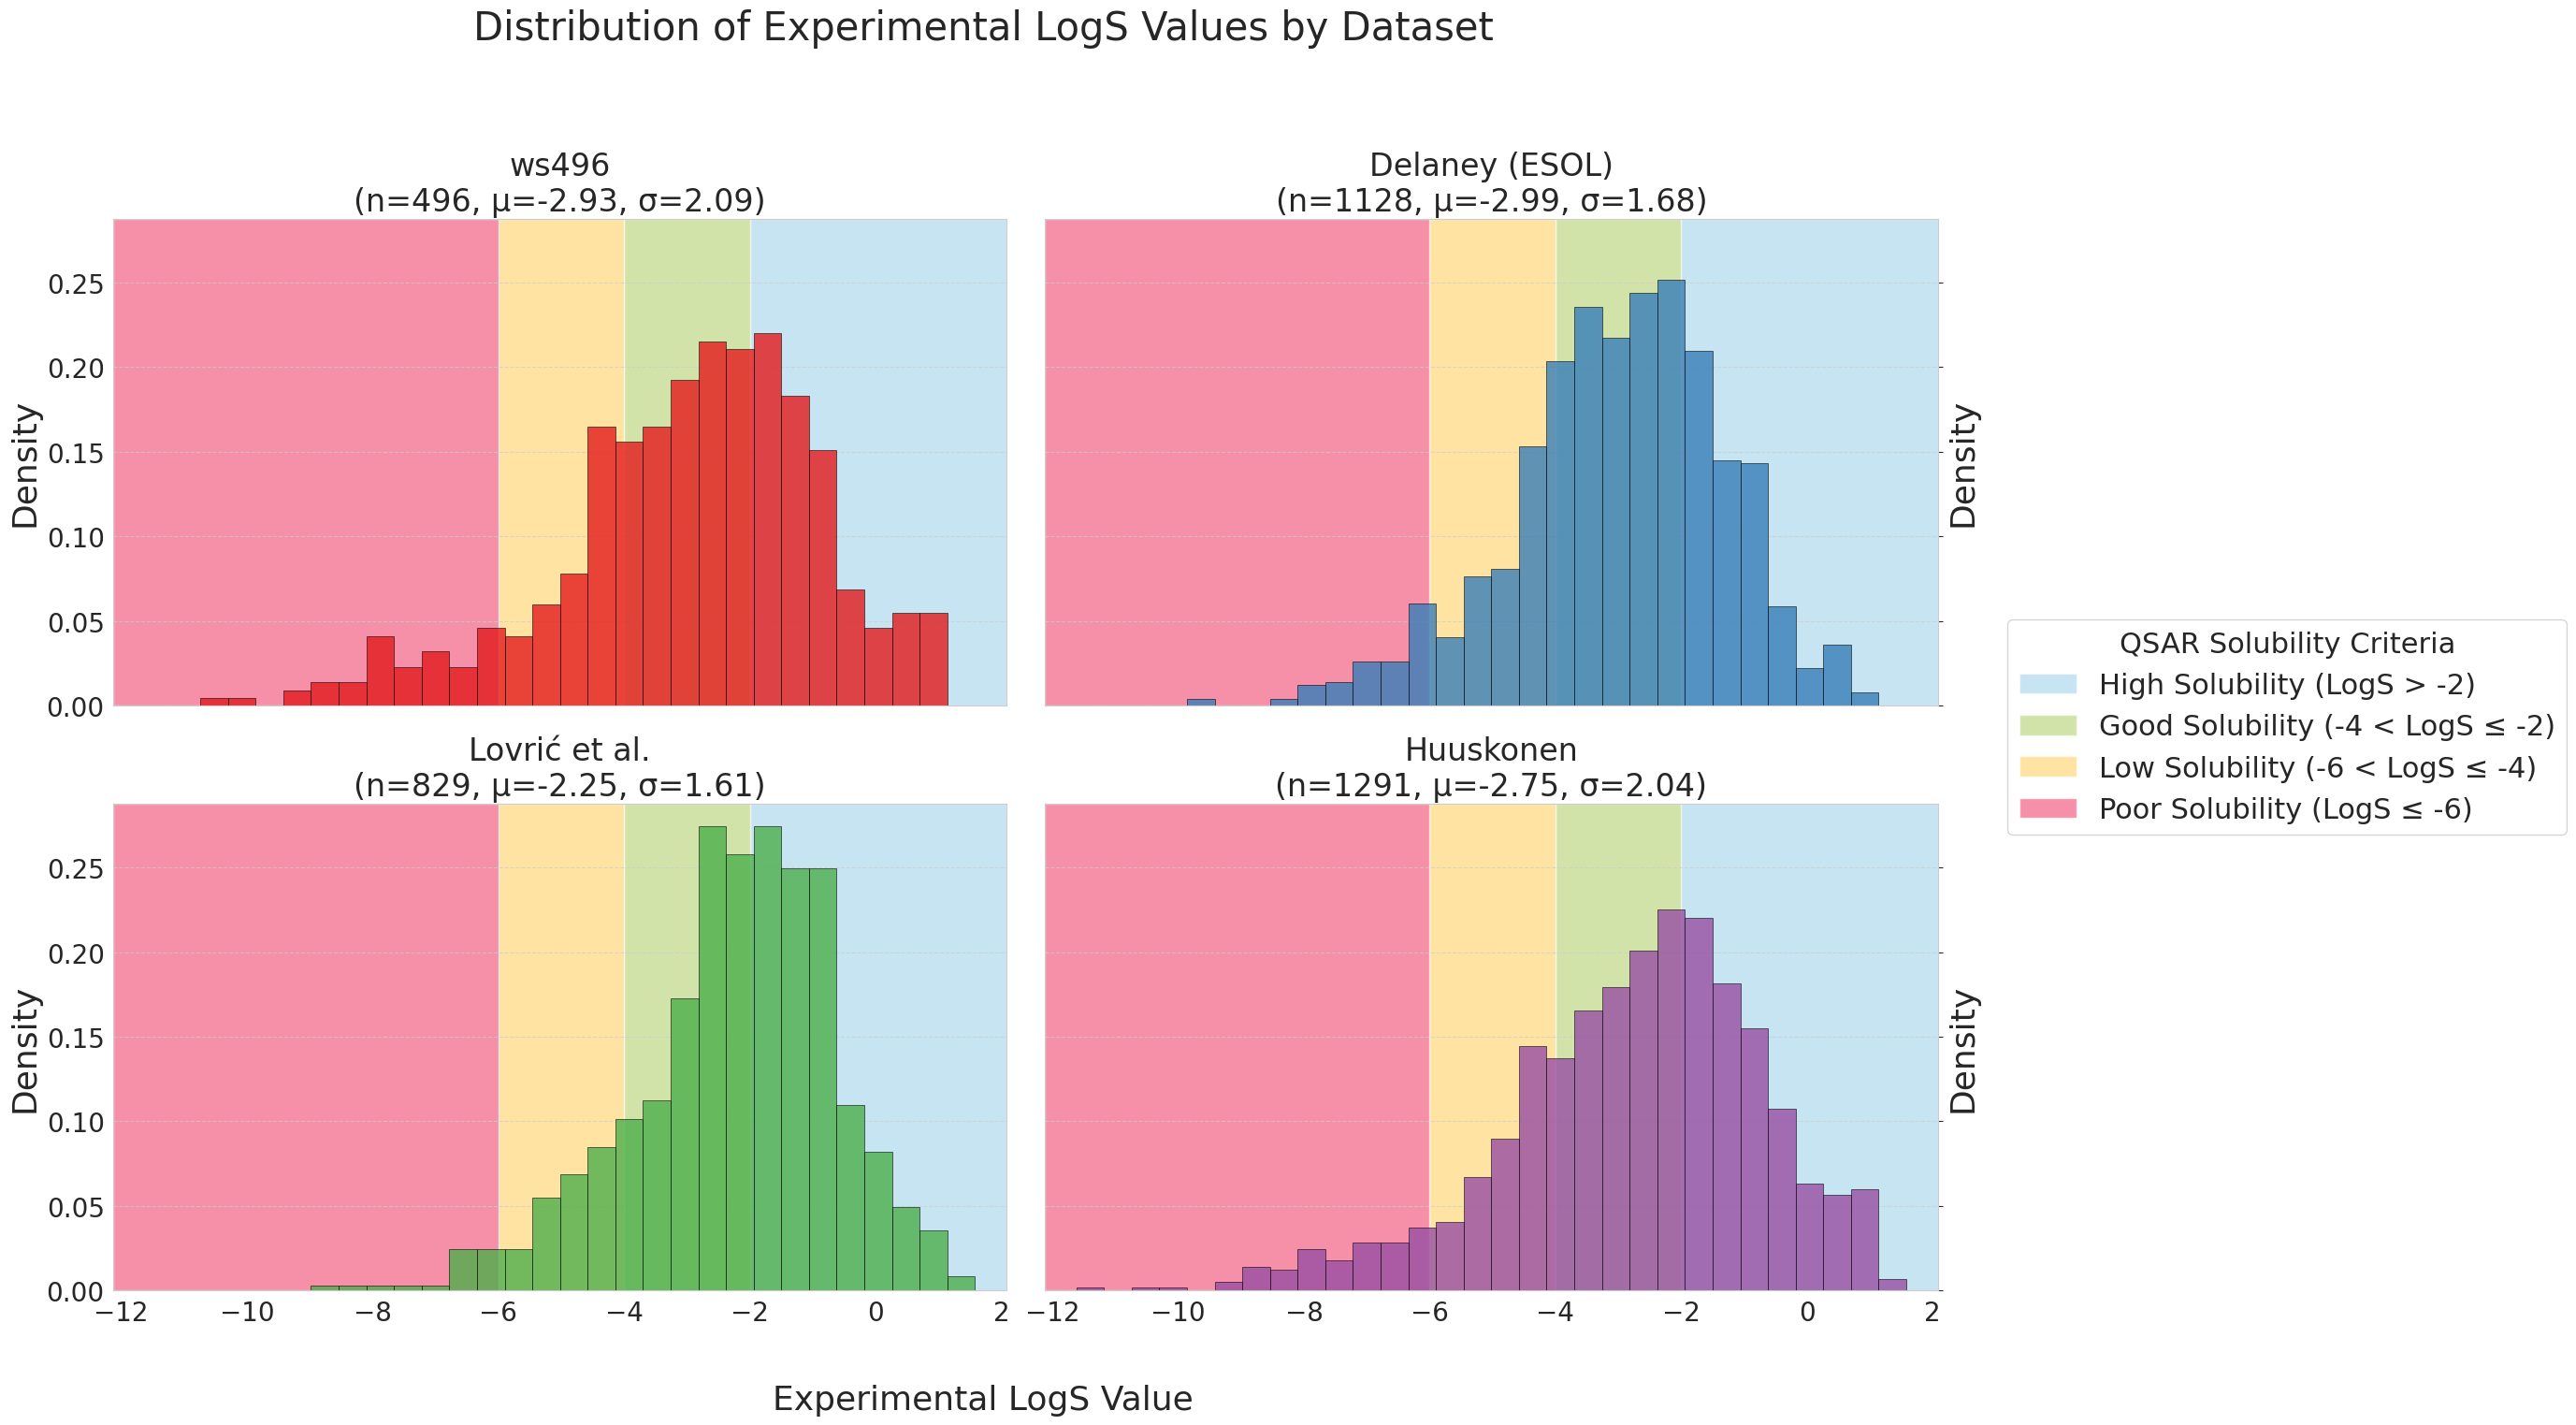

In [40]:
plot_original_datasets_distribution()

Saved: ./result/2_standard_comp/LogS_Original_Datasets2.png


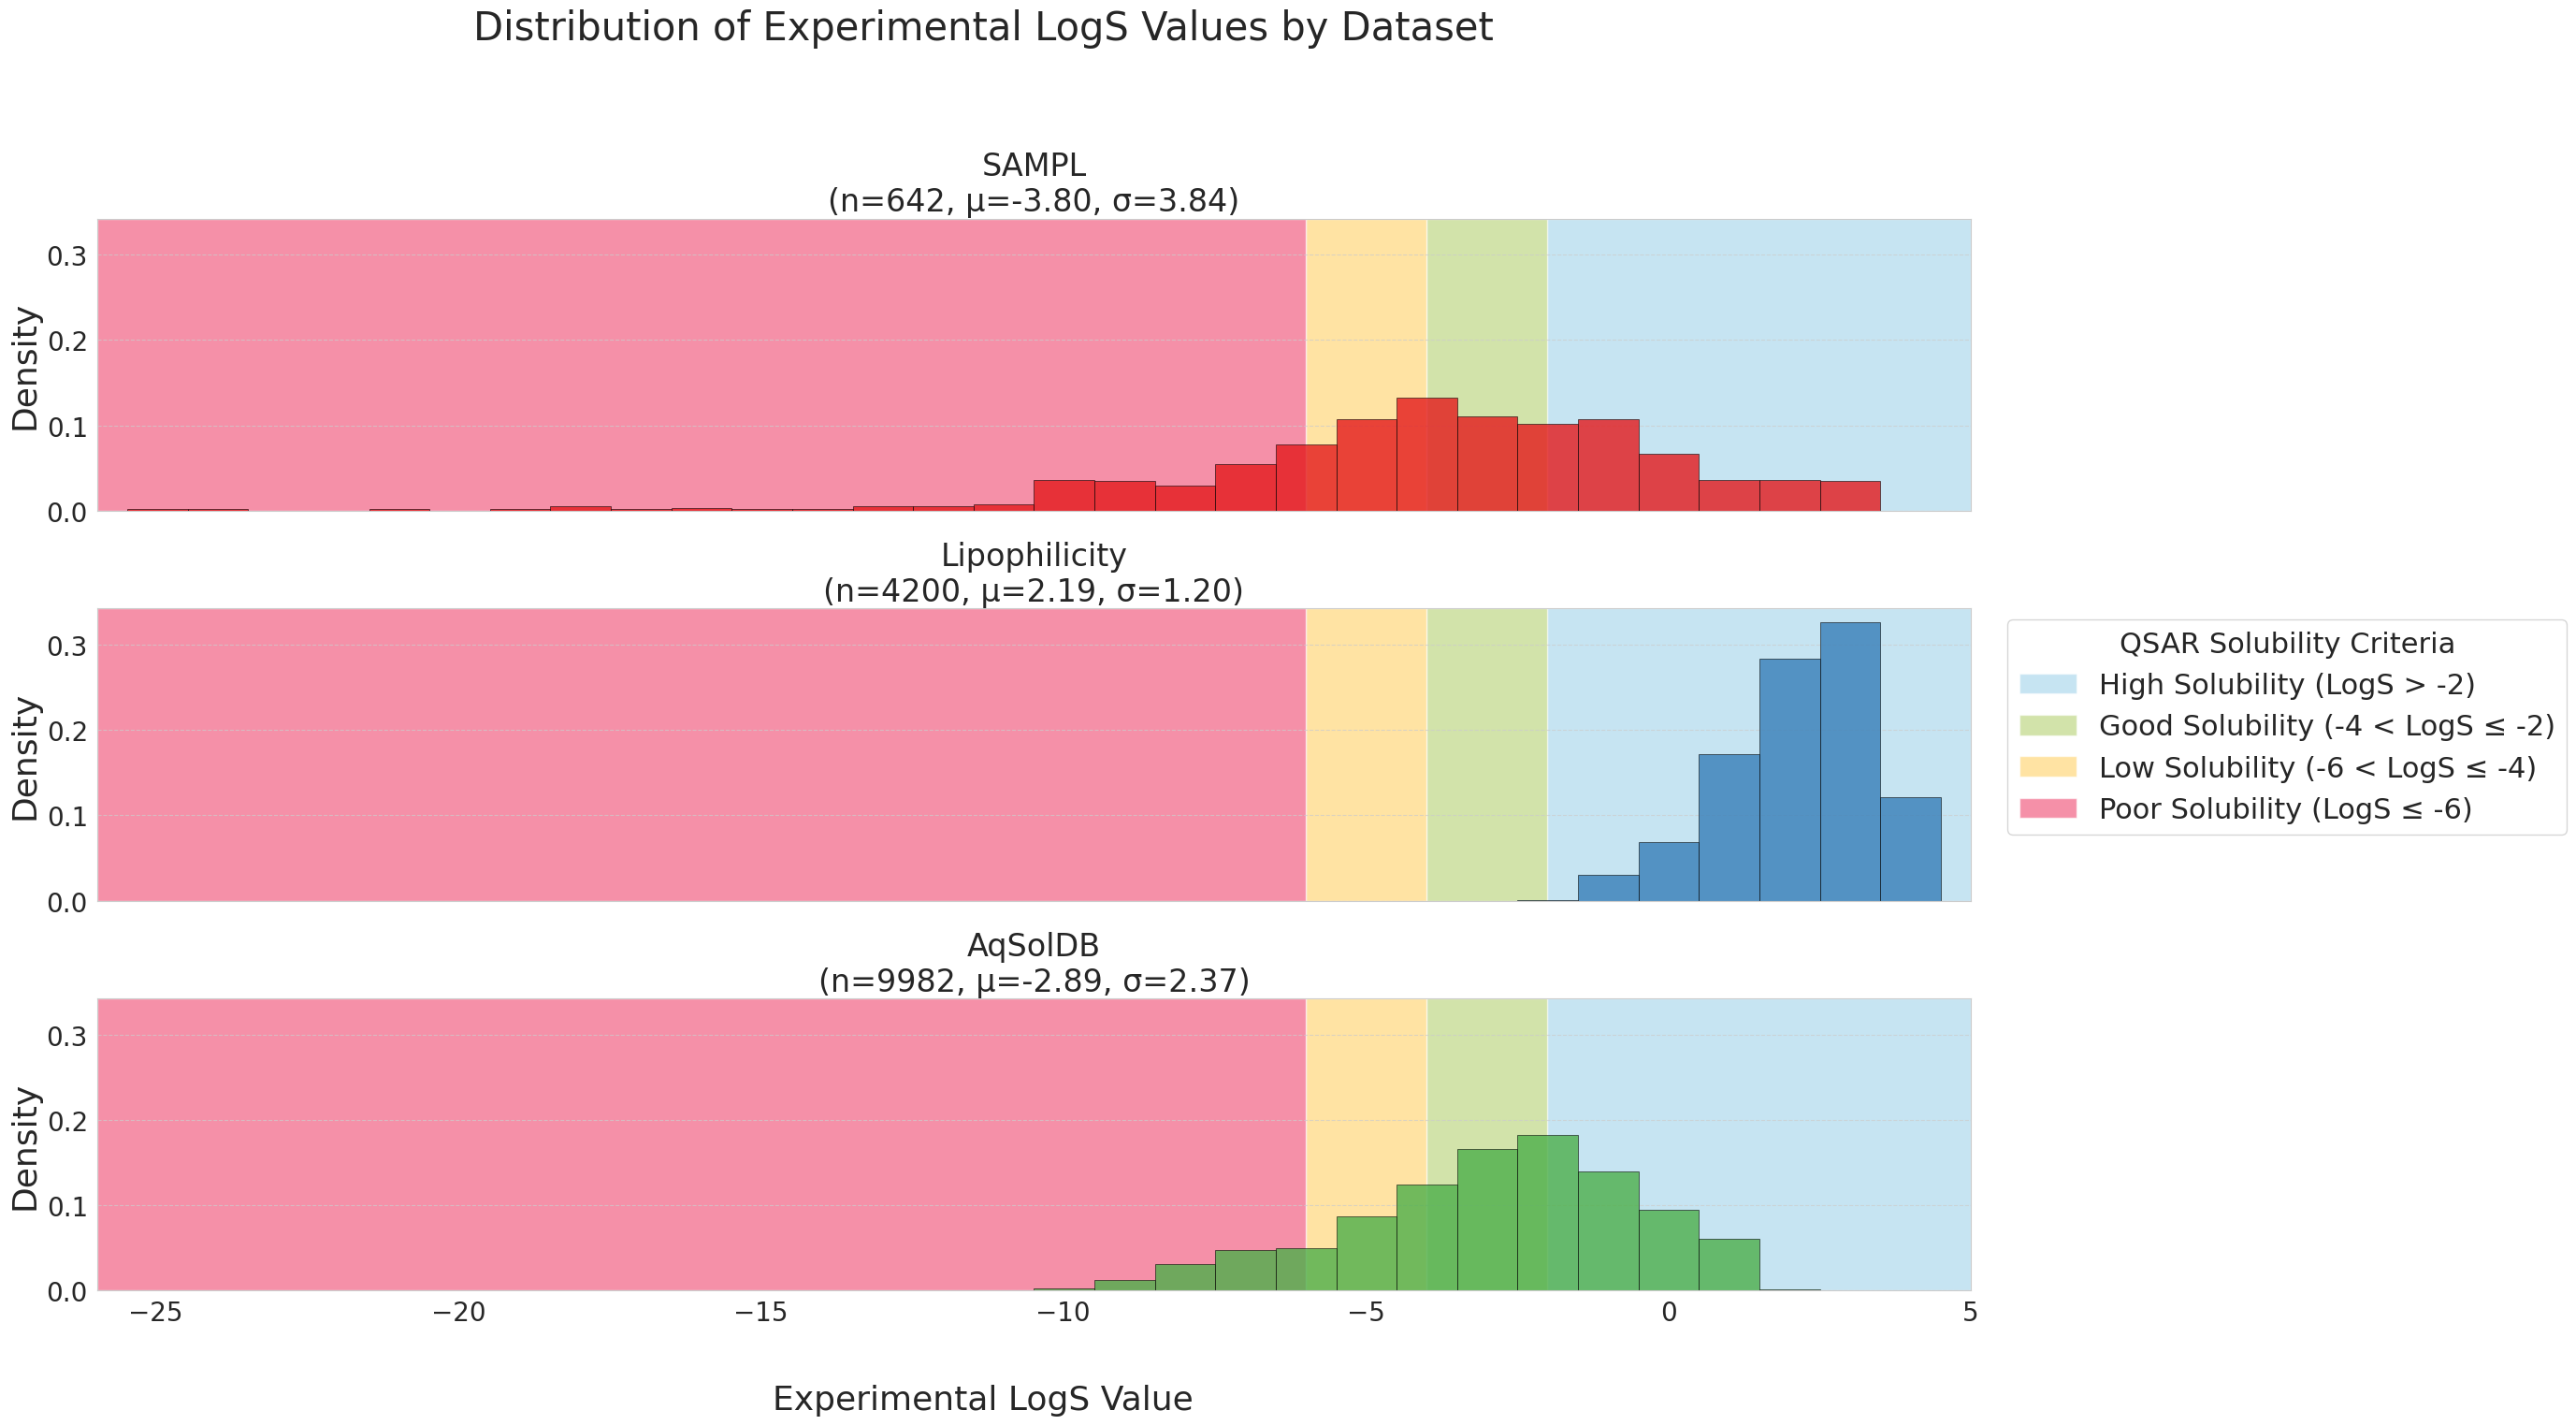

In [39]:
plot_original_datasets_distribution2()

Saved: ./result/2_standard_comp/LogS_Original_Datasets3.png


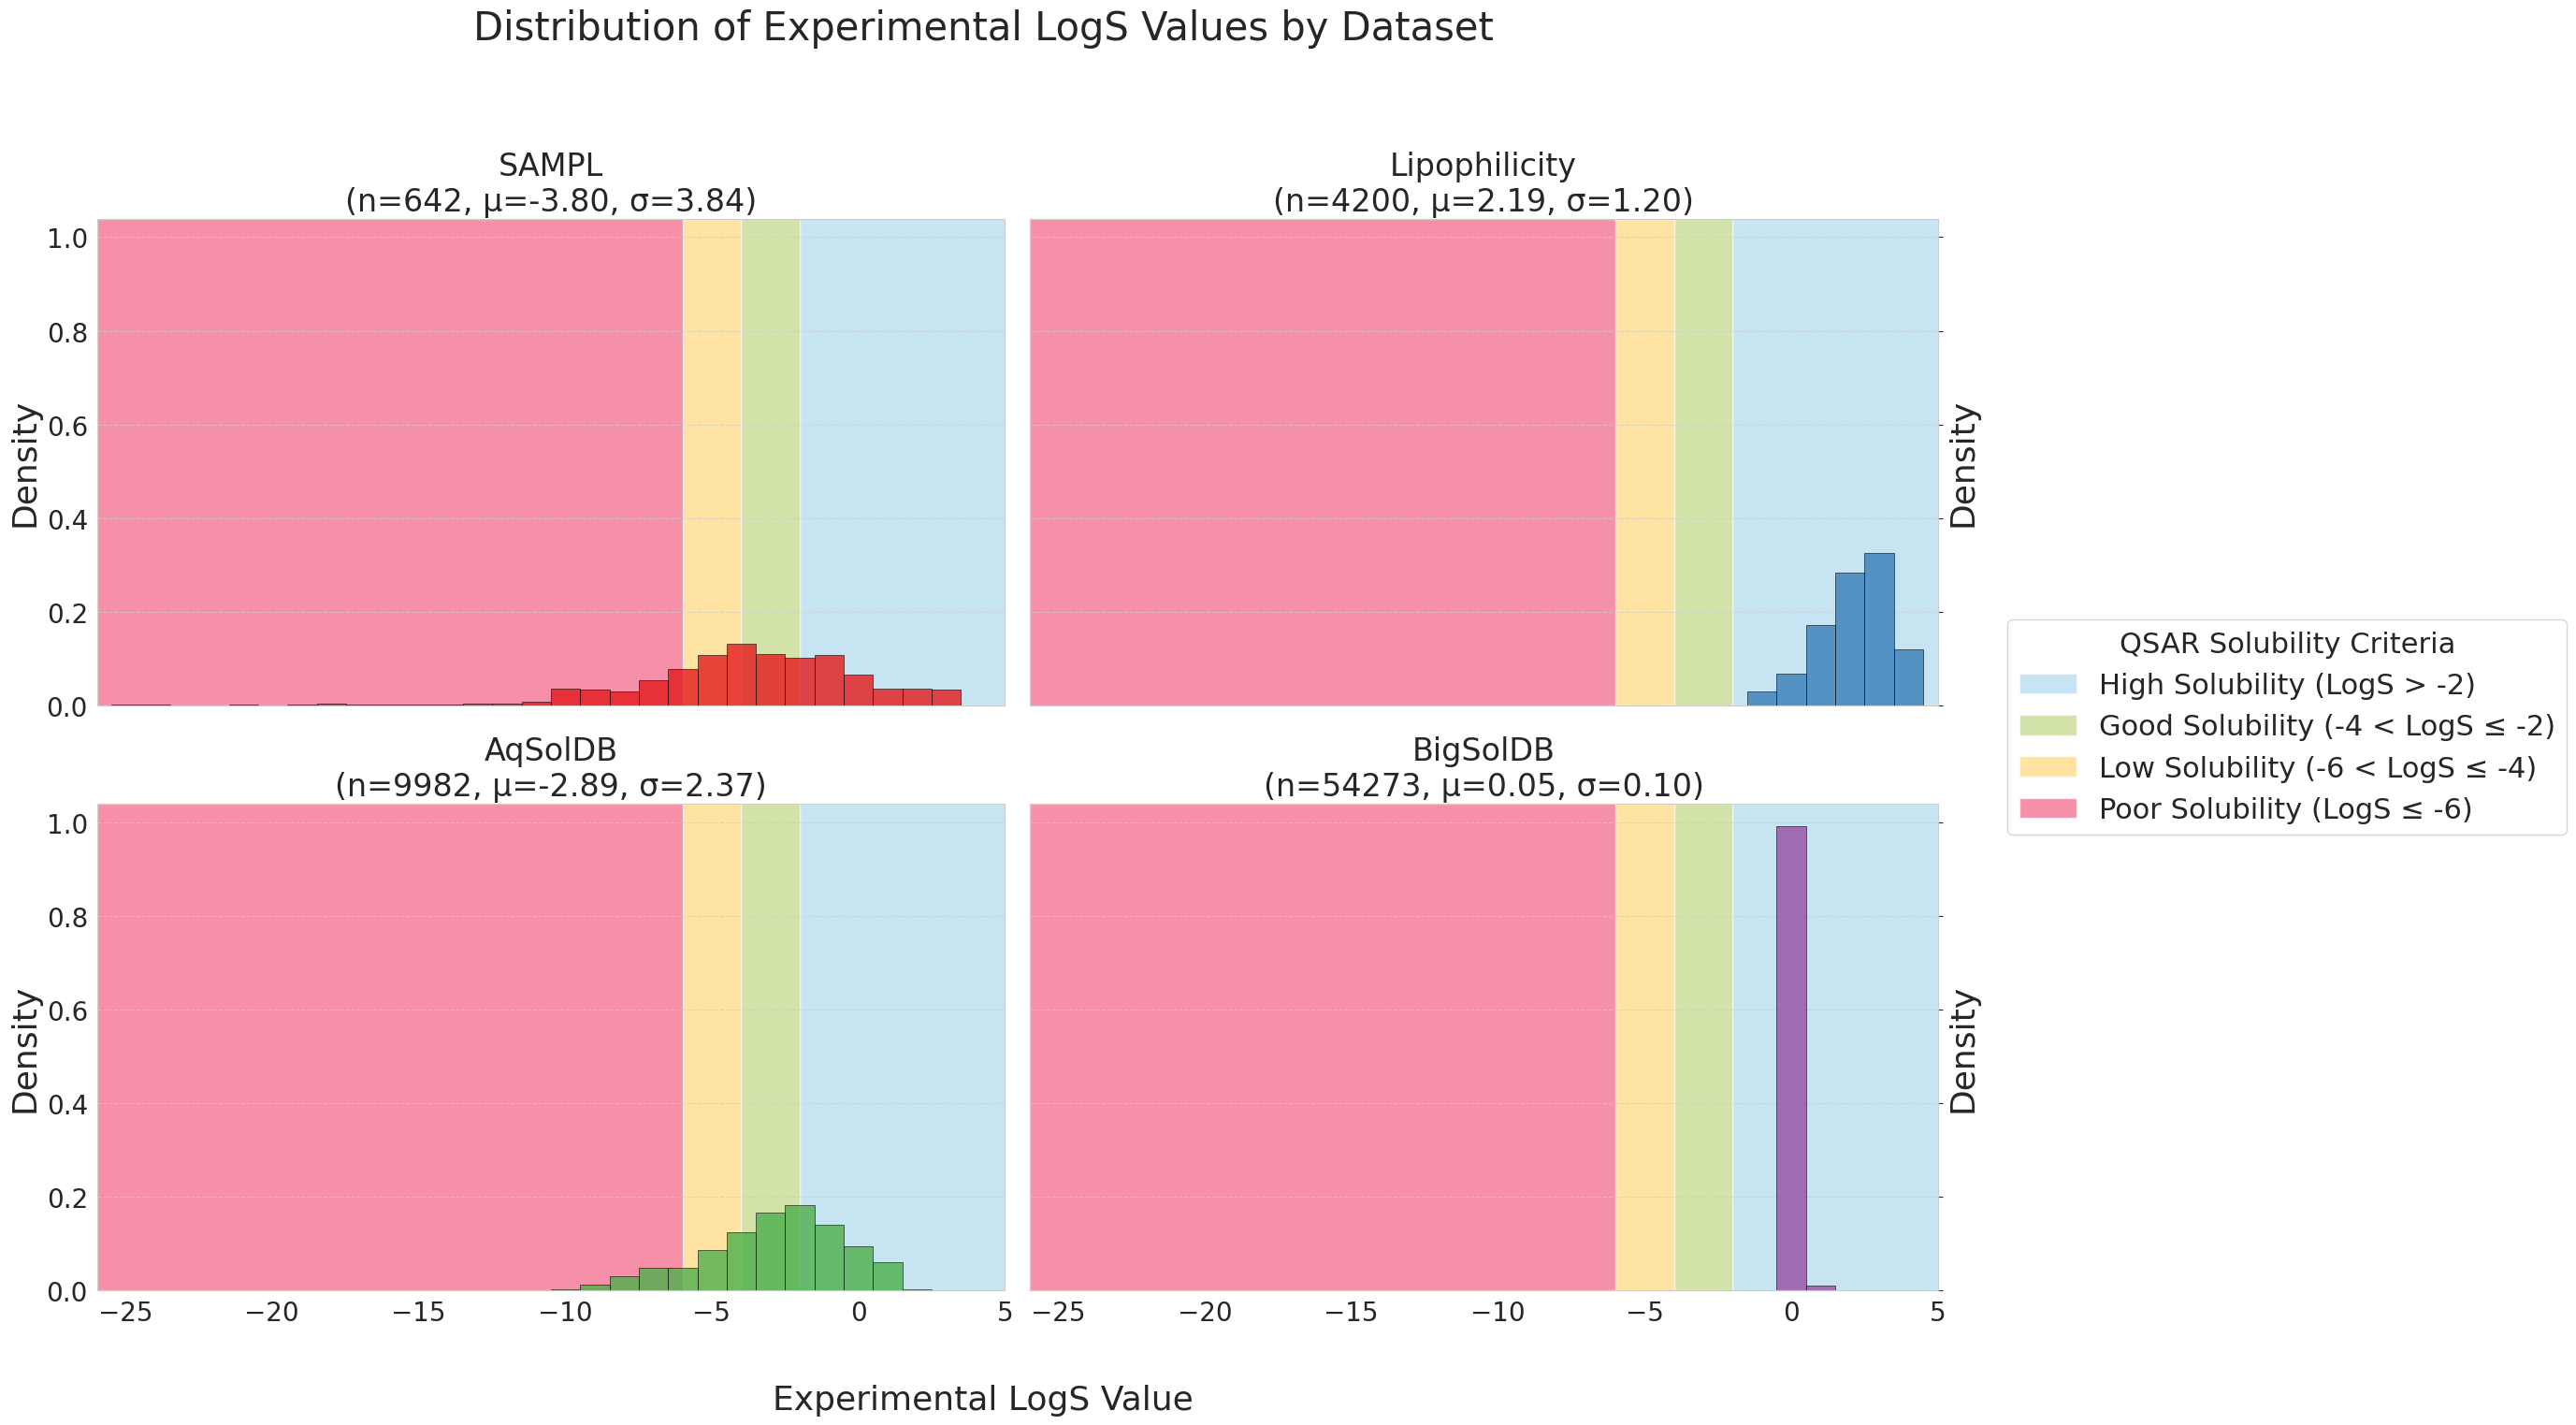

In [38]:
plot_original_datasets_distribution3()

In [ ]:
# PyTorch uses automatic mixed precision differently
# We'll set it up later in the training loop if needed

In [ ]:
class DNNModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(DNNModel, self).__init__()
        
        self.model = nn.Sequential(
            # First layer
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            
            # Second layer
            nn.Linear(1024, 496),
            nn.ReLU(),
            nn.BatchNorm1d(496),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(496, 1)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.model(x)

def new_model(input_shape):
    """Create a new PyTorch model with the same architecture"""
    model = DNNModel(input_shape)
    return model

def save_model(x_data, verbose: bool = False) -> Path:
    """Save model architecture for PyTorch"""
    model_dir = Path("save_model")
    model_path = model_dir / "pytorch_model.pth"
    model_dir.mkdir(parents=True, exist_ok=True)
    
    input_dim = x_data.shape[1]
    model = new_model(input_dim)
    
    # Save model state dict (weights will be loaded later)
    torch.save({
        'input_dim': input_dim,
        'model_state_dict': model.state_dict(),
    }, model_path)
    
    if verbose:
        print(f"[save_model] Model saved at {model_path} with input_dim={input_dim}")
    
    return model_path

In [14]:
def metric_prediction(y_true, y_pred):
    """Calculate regression metrics"""
    return {
        'r2': r2_score(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred)
    }

In [ ]:
import subprocess
import logging

# Environment settings for PyTorch
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
env = os.environ.copy()

# Set up logging
logging.basicConfig(level=logging.INFO)

In [ ]:
def train_dnn_pytorch(X_train, y_train, X_test, y_test, epochs=100, batch_size=32, lr=0.001, device='cuda'):
    """Train DNN model using PyTorch directly (no subprocess)"""
    try:
        # Convert to PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train).reshape(-1, 1)
        X_test = torch.FloatTensor(X_test)
        y_test = torch.FloatTensor(y_test).reshape(-1, 1)
        
        # Create model
        input_dim = X_train.shape[1]
        model = DNNModel(input_dim).to(device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        
        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Training loop
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            if (epoch + 1) % 20 == 0:
                avg_loss = epoch_loss / len(train_loader)
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            X_test_device = X_test.to(device)
            y_pred = model(X_test_device).cpu().numpy()
            y_test_np = y_test.numpy()
            
            # Calculate metrics
            r2 = r2_score(y_test_np, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
            mae = mean_absolute_error(y_test_np, y_pred)
            
            metrics = {
                'r2': r2,
                'rmse': rmse,
                'mae': mae,
                'mse': rmse ** 2
            }
            
            print(f"R2: {r2:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
        
        return y_pred.flatten(), metrics
        
    except Exception as e:
        print(f"Error in PyTorch DNN training: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros_like(y_test), {'r2': 0.0, 'rmse': float('inf'), 'mae': 0.0, 'mse': float('inf')}

def _run_dnn_subprocess(X_train, y_train, X_test, y_test, 
                        mode="test", 
                        target_path: str = target_path,
                        verbose=False):
    """Wrapper function that uses PyTorch implementation instead of subprocess"""
    # Use PyTorch implementation directly
    device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
    return train_dnn_pytorch(X_train, y_train, X_test, y_test, 
                           epochs=EPOCHS, batch_size=BATCHSIZE, lr=lr, device=device_str)

In [ ]:
def train_model_simple(model_type, X_train, y_train, X_test, y_test):
    """Train model with simple train/test split - DNN uses PyTorch"""
    
    # Ensure arrays are numpy arrays
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    if model_type == 'DNN':
        # Use PyTorch implementation
        device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
        y_pred, _ = train_dnn_pytorch(
            X_train, y_train, X_test, y_test,
            epochs=EPOCHS, batch_size=BATCHSIZE, lr=lr, device=device_str
        )
        return y_pred, None
    else:
        # Traditional ML models
        models = {
            'Ridge': Ridge(),
            'SVR': SVR(),
            'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
            'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
            'LightGBM': lgb.LGBMRegressor(
                random_state=RANDOM_STATE, 
                n_jobs=-1, 
                verbose=-1,
                enable_categorical=False,
                force_row_wise=True
            )
        }        
        model = models[model_type]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        return y_pred, None

In [ ]:
def train_model_cv(model_type, X_train, y_train, X_test, y_test, n_folds=5):
    """Train model with k-fold cross-validation - DNN uses PyTorch"""
    
    # Ensure arrays are numpy arrays
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_predictions = []
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold+1}/{n_folds}", end='\r')
        
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        if model_type == 'DNN':
            # Use PyTorch implementation
            device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
            test_pred, _ = train_dnn_pytorch(
                X_tr, y_tr, X_test, y_test,
                epochs=EPOCHS, batch_size=BATCHSIZE, lr=lr, device=device_str
            )
            test_predictions.append(test_pred)
            
        else:
            # Traditional ML models
            models = {
                'Ridge': Ridge(),
                'SVR': SVR(),
                'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
                'LightGBM': lgb.LGBMRegressor(
                    random_state=RANDOM_STATE, 
                    n_jobs=-1, 
                    verbose=-1,
                    enable_categorical=False,
                    force_row_wise=True
                )
            }
            
            model = models[model_type]
            model.fit(X_tr, y_tr)
            
            # Predict on test set
            test_pred = model.predict(X_test)
            test_predictions.append(test_pred)
    
    # Average predictions across folds
    y_pred = np.mean(test_predictions, axis=0)
    
    return y_pred, test_predictions

In [19]:
def run_full_experiment_with_predictions(fp_map, y_map, output_dir="result/2_standard_comp"):
    """Run experiments and save predictions for visualization"""
    
    all_results = []
    all_predictions = {}  # Store predictions for later visualization
    
    # Model types to test
    model_types = ['Ridge', 'SVR', 'RandomForest', 'XGBoost', 'LightGBM', 'DNN']
    
    # Fingerprint types
    fp_types = ['morgan','maccs', 'avalon']  # You can add 'maccs', 'avalon' later
    
    # Get all available split types
    available_splits = list(fp_map.keys())
    
    total_combinations = 0
    completed_combinations = 0
    
    # Count total combinations first
    for split_type in available_splits:
        datasets = set()
        for key in fp_map[split_type].keys():
            dataset = key.split('_')[0]
            datasets.add(dataset)
        
        for dataset in datasets:
            train_key = f"{dataset}_train"
            test_key = f"{dataset}_test"
            if train_key in fp_map[split_type] and test_key in fp_map[split_type]:
                total_combinations += len(fp_types) * len(model_types)
    
    print(f"Total combinations to run: {total_combinations}")
    
    for split_type in available_splits:
        print(f"\n{'='*60}")
        print(f"Processing split: {split_type} ({SPLIT_MAP.get(split_type, 'unknown')})")
        print(f"{'='*60}")
        
        # Initialize predictions storage for this split
        if split_type not in all_predictions:
            all_predictions[split_type] = {}
        
        datasets = set()
        for key in fp_map[split_type].keys():
            dataset = key.split('_')[0]
            datasets.add(dataset)
        
        for dataset in datasets:
            train_key = f"{dataset}_train"
            test_key = f"{dataset}_test"
            
            if train_key not in fp_map[split_type] or test_key not in fp_map[split_type]:
                print(f"Skipping {dataset}: missing train or test data")
                continue
            
            print(f"\nDataset: {dataset}")
            
            # Initialize dataset predictions storage
            if dataset not in all_predictions[split_type]:
                all_predictions[split_type][dataset] = {}
            
            # Get target values
            y_train = np.array(y_map[split_type][train_key])
            y_test = np.array(y_map[split_type][test_key])
            
            print(f"  Train size: {len(y_train)}, Test size: {len(y_test)}")
            
            for fp_type in fp_types:
                print(f"  Fingerprint: {fp_type}")
                
                if fp_type not in all_predictions[split_type][dataset]:
                    all_predictions[split_type][dataset][fp_type] = {}
                
                # Get fingerprints
                X_train = fp_map[split_type][train_key][fp_type]
                X_test = fp_map[split_type][test_key][fp_type]
                
                # Scale features
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                for model_type in model_types:
                    completed_combinations += 1
                    progress = (completed_combinations / total_combinations) * 100
                    print(f"    Model: {model_type} ({completed_combinations}/{total_combinations} - {progress:.1f}%)")
                    
                    # Choose scaled or unscaled features based on model
                    if model_type in ['SVR', 'Ridge']:
                        X_tr, X_te = X_train_scaled, X_test_scaled
                    else:
                        X_tr, X_te = X_train, X_test
                    
                    # Simple training
                    try:
                        import time
                        start_time = time.time()
                        y_pred_simple, _ = train_model_simple(model_type, X_tr, y_train, X_te, y_test)
                        end_time = time.time()
                        
                        # Store predictions
                        all_predictions[split_type][dataset][fp_type][f"{model_type}_simple"] = {
                            'y_true': y_test,
                            'y_pred': y_pred_simple
                        }
                        
                        metrics_simple = metric_prediction(y_test, y_pred_simple)
                        
                        result_simple = {
                            'split': split_type,
                            'dataset': dataset,
                            'fingerprint': fp_type,
                            'model': model_type,
                            'training': 'simple',
                            'train_time': end_time - start_time,
                            **metrics_simple
                        }
                        all_results.append(result_simple)
                        print(f"      Simple training - R²: {metrics_simple['r2']:.3f}, RMSE: {metrics_simple['rmse']:.3f}")
                        
                    except Exception as e:
                        print(f"      Error in simple training: {e}")
                        result_simple = {
                            'split': split_type,
                            'dataset': dataset,
                            'fingerprint': fp_type,
                            'model': model_type,
                            'training': 'simple',
                            'r2': np.nan,
                            'rmse': np.nan,
                            'mae': np.nan,
                            'mse': np.nan,
                            'error': str(e)
                        }
                        all_results.append(result_simple)
                    
                    # CV training
                    try:
                        start_time = time.time()
                        y_pred_cv, cv_preds = train_model_cv(model_type, X_tr, y_train, X_te, y_test, n_folds=CV)
                        end_time = time.time()
                        
                        # Store CV predictions
                        all_predictions[split_type][dataset][fp_type][f"{model_type}_cv"] = {
                            'y_true': y_test,
                            'y_pred': y_pred_cv,
                            'cv_preds': cv_preds  # Store individual fold predictions too
                        }
                        
                        metrics_cv = metric_prediction(y_test, y_pred_cv)
                        
                        # Calculate std from fold predictions
                        cv_pred_array = np.array(cv_preds)
                        y_pred_std = np.std(cv_pred_array, axis=0)
                        mean_std = np.mean(y_pred_std)
                        
                        fold_metrics = []
                        for fold_pred in cv_preds:
                            fold_metric = metric_prediction(y_test, fold_pred)
                            fold_metrics.append(fold_metric)
                        
                        r2_std = np.std([m['r2'] for m in fold_metrics])
                        rmse_std = np.std([m['rmse'] for m in fold_metrics])
                        mae_std = np.std([m['mae'] for m in fold_metrics])
                        
                        result_cv = {
                            'split': split_type,
                            'dataset': dataset,
                            'fingerprint': fp_type,
                            'model': model_type,
                            'training': 'cv',
                            'train_time': end_time - start_time,
                            'r2': metrics_cv['r2'],
                            'r2_std': r2_std,
                            'rmse': metrics_cv['rmse'],
                            'rmse_std': rmse_std,
                            'mae': metrics_cv['mae'],
                            'mae_std': mae_std,
                            'mse': metrics_cv['mse'],
                            'pred_std': mean_std,
                        }
                        all_results.append(result_cv)
                        
                        print(f"      CV training - R²: {metrics_cv['r2']:.3f}±{r2_std:.3f}, RMSE: {metrics_cv['rmse']:.3f}±{rmse_std:.3f}")
                        
                    except Exception as e:
                        print(f"      Error in CV training: {e}")
                        result_cv = {
                            'split': split_type,
                            'dataset': dataset,
                            'fingerprint': fp_type,
                            'model': model_type,
                            'training': 'cv',
                            'r2': np.nan,
                            'r2_std': np.nan,
                            'rmse': np.nan,
                            'rmse_std': np.nan,
                            'mae': np.nan,
                            'mae_std': np.nan,
                            'mse': np.nan,
                            'pred_std': np.nan,
                            'error': str(e)
                        }
                        all_results.append(result_cv)
    
    # Save results
    if all_results:
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(f"{output_dir}/all_results_with_predictions.csv", index=False)
        
        # Save predictions
        import pickle
        with open(f"{output_dir}/all_predictions.pkl", 'wb') as f:
            pickle.dump(all_predictions, f)
        
        return results_df, all_predictions
    else:
        print("No results generated!")
        return pd.DataFrame(), {}

In [20]:
def monitor_experiment_progress(output_dir="result/2_standard_comp"):
    """Monitor the progress of ongoing experiment"""
    import glob
    
    interim_files = glob.glob(f"{output_dir}/interim_results_*.csv")
    if interim_files:
        latest_file = max(interim_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        df = pd.read_csv(latest_file)
        
        print(f"Latest progress: {len(df)} results completed")
        print("\nCurrent performance summary:")
        
        # Show best performers so far
        best_simple = df[df['training'] == 'simple'].nlargest(5, 'r2')[['model', 'fingerprint', 'dataset', 'r2', 'rmse']]
        best_cv = df[df['training'] == 'cv'].nlargest(5, 'r2')[['model', 'fingerprint', 'dataset', 'r2', 'rmse']]
        
        print("\nTop 5 Simple Training:")
        print(best_simple.to_string(index=False))
        
        print("\nTop 5 CV Training:")
        print(best_cv.to_string(index=False))
        
        return df
    else:
        print("No interim results found")
        return None

In [21]:
def plot_performance_by_split_and_fp(results_df, training_type, dataset_colors, plot_dir):
    """Plot R2 and RMSE comparison grouped by split type and fingerprint"""
    
    # Filter by training type
    df = results_df[results_df['training'] == training_type].copy()
    
    # Get unique splits and fingerprints
    splits = df['split'].unique()
    fingerprints = df['fingerprint'].unique()
    models = df['model'].unique()
    
    # Create figure with subplots for R2 and RMSE
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Setup for grouped bar chart
    n_models = len(models)
    n_datasets = 4  # de, lo, ws, hu
    bar_width = 0.8 / n_models
    
    for metric_idx, (ax, metric) in enumerate([(ax1, 'r2'), (ax2, 'rmse')]):
        ax.set_title(f'{metric.upper()} Comparison - {training_type.capitalize()} Training', 
                     fontsize=20, fontweight='bold')
        
        # Create x positions for each split-fingerprint combination
        x_base = 0
        x_ticks = []
        x_labels = []
        
        for split in splits:
            for fp in fingerprints:
                # Get data for this split-fingerprint combination
                subset = df[(df['split'] == split) & (df['fingerprint'] == fp)]
                
                if subset.empty:
                    continue
                
                x_ticks.append(x_base + (n_models * bar_width) / 2)
                x_labels.append(f"{split}\n{fp}")
                
                # Plot bars for each model
                for model_idx, model in enumerate(models):
                    model_data = subset[subset['model'] == model]
                    
                    if model_data.empty:
                        continue
                    
                    x_pos = x_base + model_idx * bar_width
                    
                    # Get values for each dataset
                    for dataset in ['de', 'lo', 'ws', 'hu']:
                        dataset_data = model_data[model_data['dataset'] == dataset]
                        
                        if not dataset_data.empty:
                            value = dataset_data[metric].values[0]
                            
                            if training_type == 'cv' and not np.isnan(value):
                                # Add error bars for CV
                                std_col = f"{metric}_std"
                                if std_col in dataset_data.columns:
                                    error = dataset_data[std_col].values[0]
                                else:
                                    error = 0
                                ax.bar(x_pos, value, bar_width/4, 
                                      color=dataset_colors[dataset],
                                      yerr=error, capsize=2,
                                      label=dataset if x_base == 0 and model_idx == 0 else "")
                            else:
                                ax.bar(x_pos, value, bar_width/4,
                                      color=dataset_colors[dataset],
                                      label=dataset if x_base == 0 and model_idx == 0 else "")
                            
                            x_pos += bar_width/4
                
                x_base += n_models * bar_width + 0.5
        
        # Customize axes
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels, fontsize=12)
        ax.set_ylabel(metric.upper(), fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add legend for datasets
        if metric_idx == 0:
            ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add model labels
        if metric_idx == 1:  # Bottom plot
            # Add model legend below the plot
            model_patches = []
            for i, model in enumerate(models):
                model_patches.append(plt.Rectangle((0,0),1,1, fc='gray', alpha=0.5))
            ax.legend(model_patches, models, 
                     title='Models', loc='center', bbox_to_anchor=(0.5, -0.3),
                     ncol=len(models), frameon=True)
    
    plt.tight_layout()
    plt.savefig(plot_dir / f"performance_comparison_{training_type}.png", 
                dpi=300, bbox_inches='tight')
    plt.close()
    gc.collect()

In [22]:
def create_summary_scatter_plots(all_predictions, plot_dir):
    """Create summary scatter plots showing best models per dataset"""
    
    summary_dir = plot_dir / "summary_plots"
    summary_dir.mkdir(exist_ok=True)
    
    # Find best model for each dataset based on R2
    best_models = {}
    
    for split_type, split_data in all_predictions.items():
        for dataset, dataset_data in split_data.items():
            for fp_type, fp_data in dataset_data.items():
                for model_key, pred_data in fp_data.items():
                    if 'y_true' not in pred_data or 'y_pred' not in pred_data:
                        continue
                    
                    y_true = pred_data['y_true']
                    y_pred = pred_data['y_pred']
                    r2 = r2_score(y_true, y_pred)
                    
                    key = (split_type, dataset, fp_type)
                    if key not in best_models or r2 > best_models[key][0]:
                        best_models[key] = (r2, model_key, y_true, y_pred)
    
    # Create a figure with subplots for each dataset
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    dataset_names = {'de': 'Delaney', 'lo': 'Lovrić', 'ws': 'WS496', 'hu': 'Huuskonen'}
    
    for idx, (dataset_abbr, dataset_name) in enumerate(dataset_names.items()):
        ax = axes[idx]
        
        # Find best result for this dataset across all splits/fps
        best_r2 = -1
        best_data = None
        
        for (split_type, dataset, fp_type), (r2, model_key, y_true, y_pred) in best_models.items():
            if dataset == dataset_abbr and r2 > best_r2:
                best_r2 = r2
                best_data = (split_type, fp_type, model_key, y_true, y_pred)
        
        if best_data:
            split_type, fp_type, model_key, y_true, y_pred = best_data
            
            # Plot
            ax.scatter(y_true, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            
            # Diagonal line
            min_val = min(y_true.min(), y_pred.min())
            max_val = max(y_true.max(), y_pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
            
            # Metrics
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            model_name, training = model_key.rsplit('_', 1)
            
            ax.text(0.05, 0.95, f'R² = {best_r2:.3f}\nRMSE = {rmse:.3f}', 
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=12)
            
            ax.set_xlabel('Actual LogS', fontsize=12)
            ax.set_ylabel('Predicted LogS', fontsize=12)
            ax.set_title(f'{dataset_name}\nBest: {model_name} ({split_type}/{fp_type})',
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle('Best Model Performance per Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(summary_dir / "best_models_summary.png", dpi=300, bbox_inches='tight')
    plt.close()
    gc.collect()

In [23]:
def plot_scatter_predictions(all_predictions, plot_dir):
    """Create scatter plots of actual vs predicted values"""
    
    scatter_dir = plot_dir / "scatter_plots"
    scatter_dir.mkdir(exist_ok=True)
    
    for split_type, split_data in all_predictions.items():
        for dataset, dataset_data in split_data.items():
            for fp_type, fp_data in dataset_data.items():
                for model_key, pred_data in fp_data.items():
                    if 'y_true' not in pred_data or 'y_pred' not in pred_data:
                        continue
                    
                    y_true = pred_data['y_true']
                    y_pred = pred_data['y_pred']
                    
                    # Create scatter plot
                    plt.figure(figsize=(8, 8))
                    
                    # Main scatter plot
                    plt.scatter(y_true, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
                    
                    # Add diagonal line
                    min_val = min(y_true.min(), y_pred.min())
                    max_val = max(y_true.max(), y_pred.max())
                    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
                    
                    # Calculate metrics
                    from sklearn.metrics import r2_score, mean_squared_error
                    r2 = r2_score(y_true, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    
                    # Add metrics to plot
                    plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}', 
                            transform=plt.gca().transAxes,
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                            verticalalignment='top', fontsize=12)
                    
                    # Labels and title
                    model_name, training = model_key.rsplit('_', 1)
                    plt.xlabel('Actual LogS', fontsize=14)
                    plt.ylabel('Predicted LogS', fontsize=14)
                    plt.title(f'{dataset.upper()} - {model_name} ({training}) - {split_type}/{fp_type}',
                             fontsize=16, fontweight='bold')
                    
                    # Grid
                    plt.grid(True, alpha=0.3)
                    
                    # Equal aspect ratio
                    plt.axis('equal')
                    
                    # Save
                    filename = f"scatter_{split_type}_{dataset}_{fp_type}_{model_key}.png"
                    plt.savefig(scatter_dir / filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    gc.collect()
    
    print(f"Saved {len(list(scatter_dir.glob('*.png')))} scatter plots to {scatter_dir}")

In [24]:
def plot_enhanced_results_comparison(results_df, all_predictions, output_dir="result/2_standard_comp"):
    """Create enhanced comparison plots as requested"""
    
    plot_dir = Path(output_dir) / "plots"
    plot_dir.mkdir(exist_ok=True)
    
    # Color scheme for datasets
    dataset_colors = {
        'de': '#1f77b4',  # blue
        'lo': '#ff7f0e',  # orange
        'ws': '#2ca02c',  # green
        'hu': '#d62728'   # red
    }
    
    # 1. Performance comparison by split type and fingerprint
    for training_type in ['simple', 'cv']:
        plot_performance_by_split_and_fp(results_df, training_type, dataset_colors, plot_dir)
    
    # 2. Scatter plots for actual vs predicted values
    plot_scatter_predictions(all_predictions, plot_dir)
    
    print(f"All plots saved to {plot_dir}")

In [25]:
data_dict = load_split_data()

In [26]:
x_map, y_map = extract_xy_from_data(data_dict)

In [27]:
fp_map = build_fingerprints_for_splits(x_map, out_root)

Generating fingerprints: 100%|██████████| 56/56 [00:00<00:00, 170.66it/s]

  ... and 46 more files


In [28]:
results_df, all_predictions = run_full_experiment_with_predictions(fp_map, y_map)
#195m

Total combinations to run: 504

Processing split: rm (random)

Dataset: lo
  Train size: 663, Test size: 166
  Fingerprint: morgan
    Model: Ridge (1/504 - 0.2%)
      Simple training - R²: 0.486, RMSE: 1.124
      CV training - R²: 0.562±0.035, RMSE: 1.037±0.038
    Model: SVR (2/504 - 0.4%)
      Simple training - R²: 0.443, RMSE: 1.169
      CV training - R²: 0.422±0.004, RMSE: 1.192±0.004
    Model: RandomForest (3/504 - 0.6%)
      Simple training - R²: 0.542, RMSE: 1.061
      CV training - R²: 0.555±0.029, RMSE: 1.045±0.034
    Model: XGBoost (4/504 - 0.8%)
      Simple training - R²: 0.528, RMSE: 1.077
      CV training - R²: 0.580±0.029, RMSE: 1.015±0.033
    Model: LightGBM (5/504 - 1.0%)
      Simple training - R²: 0.594, RMSE: 0.999
      CV training - R²: 0.560±0.030, RMSE: 1.039±0.034
    Model: DNN (6/504 - 1.2%)
DEBUG: Data shapes after processing:
  X_train: (663, 2048), y_train: (663,)
  X_test: (166, 2048), y_test: (166,)


I0000 00:00:1751732343.809712  207846 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1751732343.812771  207846 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-07-06 01:19:05.967875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
I0000 00:00:1751732348.622376  208055 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1751732351.733455  208085 service.cc:152] XLA service 0x786a9c00f430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751732351.733489  208085 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1751732353.601429  208085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Metrics: {'r2': 0.595759, 'rmse': 0.996108, 'mae': 0.726667, 'mse': 0.9922311

In [ ]:
# ===== Configuration =====
DATASET_FULL_NAMES = {
    'de': 'Delaney ESOL',
    'lo': 'Lovric2020',
    'ws': 'Wang et al.',
    'hu': 'Huuskonen'
}

# ===== Main Analysis Function =====
def analyze_and_visualize_results(all_predictions, results_df, base_dir="result/2_standard_comp"):
    """
    통합된 결과 분석 및 시각화 함수
    """
    base_dir = Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)
    
    if results_df.empty:
        print("No results generated!")
        return
    
    print("\nStarting comprehensive analysis and visualization...")
    
    # 1. Create plots by dataset and split type
    plot_count = create_plots_by_dataset_split(all_predictions, results_df, base_dir)
    
    # 2. Create comprehensive Excel results
    excel_df = create_comprehensive_excel(all_predictions, base_dir)
    
    # 3. Save summaries by dataset and split type
    save_individual_summaries(results_df, base_dir)
    
    # 4. Save overall summary
    save_overall_summary(results_df, base_dir, plot_count)
    
    # 5. Print summary statistics
    print_summary_statistics(results_df)
    
    print(f"\n✅ Analysis complete! Created {plot_count} plots.")
    print(f"📁 All results saved to: {base_dir}")
    
    return excel_df


# ===== Plotting Functions =====
def create_plots_by_dataset_split(all_predictions, results_df, base_dir):
    """
    Dataset과 split type별로 plot 생성
    """
    plot_count = 0
    
    # Create plots for each dataset and split type combination
    for dataset in results_df['dataset'].unique():
        for split_type in results_df['split'].unique():
            subset_df = results_df[(results_df['dataset'] == dataset) & 
                                  (results_df['split'] == split_type)]
            
            if not subset_df.empty:
                # Create plot directory
                plot_dir = base_dir / "plots" / dataset / split_type
                plot_dir.mkdir(parents=True, exist_ok=True)
                
                # Create plots for each fingerprint
                for fp_type in ['morgan', 'maccs', 'avalon']:
                    if fp_type in subset_df['fingerprint'].unique():
                        count = create_comparison_plot(
                            all_predictions, dataset, split_type, fp_type, plot_dir
                        )
                        plot_count += count
    
    return plot_count


def create_comparison_plot(all_predictions, dataset, split_type, fp_type, output_dir):
    """
    단일 comparison plot 생성
    """
    # Check if data exists
    if (split_type not in all_predictions or 
        dataset not in all_predictions[split_type] or 
        fp_type not in all_predictions[split_type][dataset]):
        return 0
    
    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle(f"{DATASET_FULL_NAMES[dataset]} - {split_type.upper()} - {fp_type.upper()}", 
                 fontsize=20, fontweight='bold')
    
    # Get data
    models_data = all_predictions[split_type][dataset][fp_type]
    if not models_data:
        return 0
    
    # Get y_true (same for all models)
    first_model = list(models_data.keys())[0]
    y_true = models_data[first_model]['y_true']
    
    # Perfect prediction line
    min_val, max_val = y_true.min(), y_true.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.7)
    
    # Plot each model
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, (model_key, data) in enumerate(sorted(models_data.items())):
        y_pred = data['y_pred']
        r2 = r2_score(y_true, y_pred)
        
        # Clean model name
        if '_simple' in model_key:
            model_name = model_key.replace('_simple', '') + ' (SI)'
        else:
            model_name = model_key.replace('_cv', '') + ' (CV)'
        
        # Scatter plot
        ax.scatter(y_true, y_pred, 
                  marker=markers[idx % len(markers)],
                  color=colors[idx % len(colors)],
                  s=100, alpha=0.7, edgecolors='k', linewidth=0.5,
                  label=f"{model_name}: R²={r2:.3f}")
    
    # Formatting
    ax.set_xlabel('True Values', fontsize=14)
    ax.set_ylabel('Predicted Values', fontsize=14)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    # Save
    filename = f"{dataset}_{split_type}_{fp_type}_comparison.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    
    return 1


# ===== Excel Creation Functions =====
def create_comprehensive_excel(all_predictions, base_dir):
    """
    종합적인 Excel 파일 생성
    """
    table_dir = base_dir / "tables"
    table_dir.mkdir(parents=True, exist_ok=True)
    
    # Collect all results
    all_results = []
    
    for split_type in all_predictions:
        for dataset in all_predictions[split_type]:
            for fp_type in all_predictions[split_type][dataset]:
                for model_key in all_predictions[split_type][dataset][fp_type]:
                    data = all_predictions[split_type][dataset][fp_type][model_key]
                    y_true = data['y_true']
                    y_pred = data['y_pred']
                    
                    # Calculate metrics
                    r2 = r2_score(y_true, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    mae = mean_absolute_error(y_true, y_pred)
                    
                    # Parse model info
                    if '_simple' in model_key:
                        model_type = model_key.replace('_simple', '')
                        training = 'SI'
                    else:
                        model_type = model_key.replace('_cv', '')
                        training = 'CV'
                    
                    result = {
                        'Split': split_type.upper(),
                        'Dataset': dataset.upper(),
                        'Dataset_Full': DATASET_FULL_NAMES[dataset],
                        'Fingerprint': fp_type.upper(),
                        'Model': model_type,
                        'Training': training,
                        'R2': round(r2, 4),
                        'RMSE': round(rmse, 4),
                        'MAE': round(mae, 4),
                        'N_Samples': len(y_true)
                    }
                    
                    # Add CV statistics if available
                    if 'cv_preds' in data and data['cv_preds'] is not None:
                        cv_r2_scores = [r2_score(y_true, fold_pred) for fold_pred in data['cv_preds']]
                        result['R2_STD'] = round(np.std(cv_r2_scores), 4)
                        result['N_Folds'] = len(data['cv_preds'])
                    
                    all_results.append(result)
    
    # Create DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save to Excel with multiple sheets
    excel_path = table_dir / "comprehensive_results.xlsx"
    
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # 1. All results
        results_df.to_excel(writer, sheet_name='All_Results', index=False)
        
        # 2. Best models by dataset
        best_by_dataset = results_df.loc[results_df.groupby(['Dataset', 'Split'])['R2'].idxmax()]
        best_by_dataset.to_excel(writer, sheet_name='Best_by_Dataset', index=False)
        
        # 3. Model comparison
        model_comparison = results_df.pivot_table(
            values=['R2', 'RMSE', 'MAE'],
            index='Model',
            columns='Training',
            aggfunc='mean'
        ).round(4)
        model_comparison.to_excel(writer, sheet_name='Model_Comparison')
        
        # 4. Dataset performance
        dataset_perf = results_df.groupby(['Dataset', 'Dataset_Full']).agg({
            'R2': ['mean', 'std', 'max'],
            'RMSE': ['mean', 'std', 'min']
        }).round(4)
        dataset_perf.to_excel(writer, sheet_name='Dataset_Performance')
        
        # 5. Fingerprint performance
        fp_perf = results_df.groupby('Fingerprint').agg({
            'R2': ['mean', 'std', 'max'],
            'RMSE': ['mean', 'std', 'min']
        }).round(4)
        fp_perf.to_excel(writer, sheet_name='Fingerprint_Performance')
    
    print(f"📊 Excel file saved to: {excel_path}")
    return results_df


# ===== Summary Functions =====
def save_individual_summaries(results_df, base_dir):
    """
    Dataset과 split type별 개별 요약 저장
    """
    summary_dir = base_dir / "summaries"
    
    for dataset in results_df['dataset'].unique():
        for split_type in results_df['split'].unique():
            subset_df = results_df[(results_df['dataset'] == dataset) & 
                                  (results_df['split'] == split_type)]
            
            if not subset_df.empty:
                # Create directory
                ds_split_dir = summary_dir / dataset / split_type
                ds_split_dir.mkdir(parents=True, exist_ok=True)
                
                # Save summary
                summary_path = ds_split_dir / f"{dataset}_{split_type}_summary.txt"
                
                with open(summary_path, 'w') as f:
                    f.write("="*60 + "\n")
                    f.write(f"SUMMARY: {DATASET_FULL_NAMES[dataset]} - {split_type.upper()}\n")
                    f.write("="*60 + "\n\n")
                    
                    f.write(f"Total experiments: {len(subset_df)}\n")
                    f.write(f"Models tested: {', '.join(subset_df['model'].unique())}\n")
                    f.write(f"Fingerprints: {', '.join(subset_df['fingerprint'].unique())}\n\n")
                    
                    # Best result
                    if 'r2' in subset_df.columns:
                        best_row = subset_df.loc[subset_df['r2'].idxmax()]
                        f.write("Best Result:\n")
                        f.write(f"  Model: {best_row['model']} ({best_row['training']})\n")
                        f.write(f"  Fingerprint: {best_row['fingerprint']}\n")
                        f.write(f"  R² = {best_row['r2']:.4f}\n")
                        f.write(f"  RMSE = {best_row['rmse']:.4f}\n\n")
                    
                    # Performance by model
                    if 'r2' in subset_df.columns:
                        f.write("Performance by Model:\n")
                        model_stats = subset_df.groupby('model')['r2'].agg(['mean', 'std', 'max'])
                        for model, stats in model_stats.iterrows():
                            f.write(f"  {model}: mean={stats['mean']:.3f}, "
                                   f"std={stats['std']:.3f}, max={stats['max']:.3f}\n")


def save_overall_summary(results_df, base_dir, plot_count):
    """
    전체 요약 저장
    """
    summary_path = base_dir / "overall_summary.txt"
    
    with open(summary_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("OVERALL EXPERIMENT SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total experiments: {len(results_df)}\n")
        f.write(f"Total plots created: {plot_count}\n")
        f.write(f"Datasets: {', '.join([DATASET_FULL_NAMES[d] for d in results_df['dataset'].unique()])}\n")
        f.write(f"Models: {', '.join(results_df['model'].unique())}\n")
        f.write(f"Fingerprints: {', '.join(results_df['fingerprint'].unique())}\n")
        f.write(f"Split types: {', '.join(results_df['split'].unique())}\n\n")
        
        if 'r2' in results_df.columns:
            best_overall = results_df.loc[results_df['r2'].idxmax()]
            f.write("Best Overall Result:\n")
            f.write(f"  Dataset: {DATASET_FULL_NAMES[best_overall['dataset']]}\n")
            f.write(f"  Model: {best_overall['model']} ({best_overall['training']})\n")
            f.write(f"  Split: {best_overall['split']}\n")
            f.write(f"  Fingerprint: {best_overall['fingerprint']}\n")
            f.write(f"  R² = {best_overall['r2']:.4f}\n")
            f.write(f"  RMSE = {best_overall['rmse']:.4f}\n")


def print_summary_statistics(results_df):
    """
    콘솔에 요약 통계 출력
    """
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # Best models by dataset
    for training in ['simple', 'cv']:
        print(f"\n{training.upper()} Training Results:")
        print("-" * 40)
        
        training_df = results_df[results_df['training'] == training]
        
        for dataset in ['ws', 'de', 'lo', 'hu']:
            dataset_df = training_df[training_df['dataset'] == dataset]
            if not dataset_df.empty and 'r2' in dataset_df.columns:
                best_row = dataset_df.loc[dataset_df['r2'].idxmax()]
                print(f"\n{DATASET_FULL_NAMES[dataset]}:")
                print(f"  Best: {best_row['model']} - {best_row['fingerprint']}")
                print(f"  R² = {best_row['r2']:.3f}")
    
    # Directory structure
    print("\n📁 Created directory structure:")
    print("result/2_standard_comp/")
    print("├── plots/        # Visualization plots by dataset/split")
    print("├── tables/       # Excel and CSV files")
    print("├── summaries/    # Text summaries by dataset/split")
    print("└── overall_summary.txt")

In [30]:
if not results_df.empty:
    print("\nCreating enhanced visualizations...")
    
    # 표준 비교 플롯 생성 (각 split_type과 fingerprint별로)
    plot_count = create_standard_comparison_plots(all_predictions, results_df)
    
    # 종합 결과 테이블 생성 (CSV + Excel)
    detailed_results = create_comprehensive_results_table(results_df, all_predictions)
    
    print(f"\nVisualization complete! Created {plot_count} plots.")
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # 데이터셋 전체 이름 매핑
    dataset_full_names = {
        'de': 'Delaney ESOL',
        'lo': 'Lovric2020',
        'ws': 'Wang et al.',
        'hu': 'Huuskonen'
    }
    
    # Best models by dataset and split type
    for training in ['simple', 'cv']:
        print(f"\n{training.upper()} Training Results:")
        print("-" * 40)
        
        training_df = results_df[results_df['training'] == training]
        
        # Group by dataset and find best model
        for dataset in ['ws', 'de', 'lo', 'hu']:
            dataset_df = training_df[training_df['dataset'] == dataset]
            if not dataset_df.empty:
                best_row = dataset_df.loc[dataset_df['r2'].idxmax()]
                
                print(f"\n{dataset_full_names[dataset]} Dataset:")
                print(f"  Best Model: {best_row['model']}")
                print(f"  Split: {best_row['split']}, Fingerprint: {best_row['fingerprint']}")
                
                if training == 'cv':
                    print(f"  R² = {best_row['r2']:.3f} ± {best_row['r2_std']:.3f}")
                    print(f"  RMSE = {best_row['rmse']:.3f} ± {best_row['rmse_std']:.3f}")
                else:
                    print(f"  R² = {best_row['r2']:.3f}")
                    print(f"  RMSE = {best_row['rmse']:.3f}")
    
    # Overall best performers
    print("\n" + "="*60)
    print("TOP 5 OVERALL PERFORMERS (by R²)")
    print("="*60)
    
    for training in ['simple', 'cv']:
        print(f"\n{training.upper()} Training:")
        top_5 = results_df[results_df['training'] == training].nlargest(5, 'r2')
        
        for _, row in top_5.iterrows():
            dataset_name = dataset_full_names[row['dataset']]
            print(f"  {dataset_name}/{row['split']}/{row['fingerprint']} - {row['model']}: R²={row['r2']:.3f}")
    
    # Additional analysis from detailed results
    print("\n" + "="*60)
    print("ADDITIONAL INSIGHTS FROM DETAILED ANALYSIS")
    print("="*60)
    
    # Average performance by fingerprint type
    print("\nAverage R² by Fingerprint Type:")
    fp_avg = detailed_results.groupby('fingerprint')['r2'].agg(['mean', 'std'])
    for fp, stats in fp_avg.iterrows():
        print(f"  {fp}: {stats['mean']:.3f} ± {stats['std']:.3f}")
    
    # Average performance by split type
    print("\nAverage R² by Split Type:")
    split_avg = detailed_results.groupby('split_type')['r2'].agg(['mean', 'std'])
    for split, stats in split_avg.iterrows():
        print(f"  {split}: {stats['mean']:.3f} ± {stats['std']:.3f}")
    
    # Model consistency analysis
    print("\nModel Consistency (std across all experiments):")
    model_std = detailed_results.groupby('model')['r2'].std().sort_values()
    for model, std in model_std.items():
        print(f"  {model}: {std:.3f}")
    
    # Training method comparison
    print("\nTraining Method Comparison (average R²):")
    training_avg = detailed_results.groupby('training')['r2'].mean()
    for method, avg in training_avg.items():
        print(f"  {method}: {avg:.3f}")
    
    # Save summary to text file
    summary_path = Path("result/2_standard_comp/summary_statistics.txt")
    summary_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(summary_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("EXPERIMENT SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total experiments: {len(detailed_results)}\n")
        f.write(f"Total plots created: {plot_count}\n")
        f.write(f"Datasets: {', '.join([dataset_full_names[d] for d in ['ws', 'de', 'lo', 'hu']])}\n")
        f.write(f"Fingerprints: {', '.join(detailed_results['fingerprint'].unique())}\n")
        f.write(f"Models: {', '.join(detailed_results['model'].unique())}\n")
        f.write(f"Split types: {', '.join(detailed_results['split_type'].unique())}\n\n")
        
        # Best overall result
        best_overall = detailed_results.loc[detailed_results['r2'].idxmax()]
        f.write("Best Overall Result:\n")
        f.write(f"  Dataset: {dataset_full_names[best_overall['dataset']]}\n")
        f.write(f"  Model: {best_overall['model']} ({best_overall['training']})\n")
        f.write(f"  Split: {best_overall['split_type']}\n")
        f.write(f"  Fingerprint: {best_overall['fingerprint']}\n")
        f.write(f"  R² = {best_overall['r2']:.4f}\n")
        f.write(f"  RMSE = {best_overall['rmse']:.4f}\n")
    
    print(f"\nSummary saved to: {summary_path}")
    
else:
    print("No results generated!")


Creating enhanced visualizations...
Saved: 1_standard_model_compare_ac_morgan.png
Saved: 1_standard_model_compare_ac_maccs.png
Saved: 1_standard_model_compare_ac_avalon.png
Saved: 1_standard_model_compare_cl_morgan.png
Saved: 1_standard_model_compare_cl_maccs.png
Saved: 1_standard_model_compare_cl_avalon.png
Saved: 1_standard_model_compare_cs_morgan.png
Saved: 1_standard_model_compare_cs_maccs.png
Saved: 1_standard_model_compare_cs_avalon.png
Saved: 1_standard_model_compare_en_morgan.png
Saved: 1_standard_model_compare_en_maccs.png
Saved: 1_standard_model_compare_en_avalon.png
Saved: 1_standard_model_compare_pc_morgan.png
Saved: 1_standard_model_compare_pc_maccs.png
Saved: 1_standard_model_compare_pc_avalon.png
Saved: 1_standard_model_compare_rm_morgan.png
Saved: 1_standard_model_compare_rm_maccs.png
Saved: 1_standard_model_compare_rm_avalon.png
Saved: 1_standard_model_compare_sa_morgan.png
Saved: 1_standard_model_compare_sa_maccs.png
Saved: 1_standard_model_compare_sa_avalon.png

Tot

In [33]:
if not results_df.empty:
    print("\nCreating enhanced visualizations...")
    
    # 데이터셋 전체 이름 매핑
    dataset_full_names = {
        'de': 'Delaney ESOL',
        'lo': 'Lovric2020',
        'ws': 'Wang et al.',
        'hu': 'Huuskonen'
    }
    
    # Base directory for results
    base_dir = Path("result/2_standard_comp")
    
    # Create plots by dataset and split type
    plot_count = 0
    for dataset in results_df['dataset'].unique():
        for split_type in results_df['split'].unique():
            # Filter data for this dataset and split
            subset_df = results_df[(results_df['dataset'] == dataset) & 
                                  (results_df['split'] == split_type)]
            
            if not subset_df.empty:
                # Create plot directory
                plot_dir = base_dir / "plots" / dataset / split_type
                plot_dir.mkdir(parents=True, exist_ok=True)
                
                # Create plots for this subset
                subset_predictions = {k: v for k, v in all_predictions.items() 
                                    if k[0] == dataset and k[1] == split_type}
                
                if subset_predictions:
                    # Call plotting function with specific output directory
                    count = create_standard_comparison_plots(
                        subset_predictions, 
                        subset_df, 
                        output_dir=plot_dir
                    )
                    plot_count += count
    
    # Create comprehensive results tables by dataset and split type
    print("\nCreating result tables by dataset and split...")
    
    for dataset in results_df['dataset'].unique():
        for split_type in results_df['split'].unique():
            # Filter data
            subset_df = results_df[(results_df['dataset'] == dataset) & 
                                  (results_df['split'] == split_type)]
            
            if not subset_df.empty:
                # Create table directory
                table_dir = base_dir / "tables" / dataset / split_type
                table_dir.mkdir(parents=True, exist_ok=True)
                
                # Create subset predictions
                subset_predictions = {k: v for k, v in all_predictions.items() 
                                    if k[0] == dataset and k[1] == split_type}
                
                # Create detailed results table for this subset
                detailed_results = create_comprehensive_results_table(
                    subset_df, 
                    subset_predictions,
                    output_dir=table_dir,
                    filename_prefix=f"{dataset}_{split_type}"
                )
    
    print(f"\nVisualization complete! Created {plot_count} plots.")
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # Best models by dataset and split type
    for training in ['simple', 'cv']:
        print(f"\n{training.upper()} Training Results:")
        print("-" * 40)
        
        training_df = results_df[results_df['training'] == training]
        
        # Group by dataset and find best model
        for dataset in ['ws', 'de', 'lo', 'hu']:
            dataset_df = training_df[training_df['dataset'] == dataset]
            if not dataset_df.empty:
                best_row = dataset_df.loc[dataset_df['r2'].idxmax()]
                
                print(f"\n{dataset_full_names[dataset]} Dataset:")
                print(f"  Best Model: {best_row['model']}")
                print(f"  Split: {best_row['split']}, Fingerprint: {best_row['fingerprint']}")
                
                if training == 'cv':
                    print(f"  R² = {best_row['r2']:.3f} ± {best_row['r2_std']:.3f}")
                    print(f"  RMSE = {best_row['rmse']:.3f} ± {best_row['rmse_std']:.3f}")
                else:
                    print(f"  R² = {best_row['r2']:.3f}")
                    print(f"  RMSE = {best_row['rmse']:.3f}")
    
    # Overall best performers
    print("\n" + "="*60)
    print("TOP 5 OVERALL PERFORMERS (by R²)")
    print("="*60)
    
    for training in ['simple', 'cv']:
        print(f"\n{training.upper()} Training:")
        top_5 = results_df[results_df['training'] == training].nlargest(5, 'r2')
        
        for _, row in top_5.iterrows():
            dataset_name = dataset_full_names[row['dataset']]
            print(f"  {dataset_name}/{row['split']}/{row['fingerprint']} - {row['model']}: R²={row['r2']:.3f}")
    
    # Save individual summaries by dataset and split type
    print("\nSaving summaries by dataset and split type...")
    
    for dataset in results_df['dataset'].unique():
        for split_type in results_df['split'].unique():
            subset_df = results_df[(results_df['dataset'] == dataset) & 
                                  (results_df['split'] == split_type)]
            
            if not subset_df.empty:
                # Create summary directory
                summary_dir = base_dir / "summaries" / dataset / split_type
                summary_dir.mkdir(parents=True, exist_ok=True)
                
                # Save dataset/split specific summary
                summary_path = summary_dir / f"{dataset}_{split_type}_summary.txt"
                
                with open(summary_path, 'w') as f:
                    f.write("="*60 + "\n")
                    f.write(f"SUMMARY: {dataset_full_names[dataset]} - {split_type.upper()}\n")
                    f.write("="*60 + "\n\n")
                    
                    f.write(f"Total experiments: {len(subset_df)}\n")
                    f.write(f"Fingerprints tested: {', '.join(subset_df['fingerprint'].unique())}\n")
                    f.write(f"Models tested: {', '.join(subset_df['model'].unique())}\n\n")
                    
                    # Best result for this dataset/split
                    best_row = subset_df.loc[subset_df['r2'].idxmax()]
                    f.write("Best Result:\n")
                    f.write(f"  Model: {best_row['model']} ({best_row['training']})\n")
                    f.write(f"  Fingerprint: {best_row['fingerprint']}\n")
                    f.write(f"  R² = {best_row['r2']:.4f}\n")
                    f.write(f"  RMSE = {best_row['rmse']:.4f}\n\n")
                    
                    # Performance by model
                    f.write("Performance by Model:\n")
                    model_stats = subset_df.groupby('model')['r2'].agg(['mean', 'std', 'max'])
                    for model, stats in model_stats.iterrows():
                        f.write(f"  {model}: mean={stats['mean']:.3f}, std={stats['std']:.3f}, max={stats['max']:.3f}\n")
                    
                    f.write("\nPerformance by Fingerprint:\n")
                    fp_stats = subset_df.groupby('fingerprint')['r2'].agg(['mean', 'std', 'max'])
                    for fp, stats in fp_stats.iterrows():
                        f.write(f"  {fp}: mean={stats['mean']:.3f}, std={stats['std']:.3f}, max={stats['max']:.3f}\n")
                    
                    # Training method comparison for this subset
                    f.write("\nTraining Method Comparison:\n")
                    training_stats = subset_df.groupby('training')['r2'].agg(['mean', 'std'])
                    for method, stats in training_stats.iterrows():
                        f.write(f"  {method}: mean={stats['mean']:.3f}, std={stats['std']:.3f}\n")
    
    # Also save overall summary
    overall_summary_path = base_dir / "overall_summary.txt"
    
    with open(overall_summary_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("OVERALL EXPERIMENT SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total experiments: {len(results_df)}\n")
        f.write(f"Total plots created: {plot_count}\n")
        f.write(f"Datasets: {', '.join([dataset_full_names[d] for d in results_df['dataset'].unique()])}\n")
        f.write(f"Fingerprints: {', '.join(results_df['fingerprint'].unique())}\n")
        f.write(f"Models: {', '.join(results_df['model'].unique())}\n")
        f.write(f"Split types: {', '.join(results_df['split'].unique())}\n\n")
        
        # Best overall result
        best_overall = results_df.loc[results_df['r2'].idxmax()]
        f.write("Best Overall Result:\n")
        f.write(f"  Dataset: {dataset_full_names[best_overall['dataset']]}\n")
        f.write(f"  Model: {best_overall['model']} ({best_overall['training']})\n")
        f.write(f"  Split: {best_overall['split']}\n")
        f.write(f"  Fingerprint: {best_overall['fingerprint']}\n")
        f.write(f"  R² = {best_overall['r2']:.4f}\n")
        f.write(f"  RMSE = {best_overall['rmse']:.4f}\n\n")
        
        # Overall statistics
        f.write("Overall Statistics:\n")
        f.write(f"  Average R² across all experiments: {results_df['r2'].mean():.3f}\n")
        f.write(f"  Standard deviation of R²: {results_df['r2'].std():.3f}\n")
        f.write(f"  Best R²: {results_df['r2'].max():.3f}\n")
        f.write(f"  Worst R²: {results_df['r2'].min():.3f}\n")
    
    print(f"\nAll summaries saved to: {base_dir}")
    
    # Print directory structure
    print("\nCreated directory structure:")
    print("result/2_standard_comp/")
    print("├── plots/")
    print("│   ├── dataset1/")
    print("│   │   ├── split1/")
    print("│   │   └── split2/")
    print("│   └── dataset2/...")
    print("├── tables/")
    print("│   └── (same structure)")
    print("├── summaries/")
    print("│   └── (same structure)")
    print("└── overall_summary.txt")
    
else:
    print("No results generated!")


Creating enhanced visualizations...
Saved: 1_standard_model_compare_ac_morgan.png
Saved: 1_standard_model_compare_ac_maccs.png
Saved: 1_standard_model_compare_ac_avalon.png
Saved: 1_standard_model_compare_cl_morgan.png
Saved: 1_standard_model_compare_cl_maccs.png
Saved: 1_standard_model_compare_cl_avalon.png
Saved: 1_standard_model_compare_cs_morgan.png
Saved: 1_standard_model_compare_cs_maccs.png
Saved: 1_standard_model_compare_cs_avalon.png
Saved: 1_standard_model_compare_en_morgan.png
Saved: 1_standard_model_compare_en_maccs.png
Saved: 1_standard_model_compare_en_avalon.png
Saved: 1_standard_model_compare_pc_morgan.png
Saved: 1_standard_model_compare_pc_maccs.png
Saved: 1_standard_model_compare_pc_avalon.png
Saved: 1_standard_model_compare_rm_morgan.png
Saved: 1_standard_model_compare_rm_maccs.png
Saved: 1_standard_model_compare_rm_avalon.png
Saved: 1_standard_model_compare_sa_morgan.png
Saved: 1_standard_model_compare_sa_maccs.png
Saved: 1_standard_model_compare_sa_avalon.png

Tot